In [1]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from itertools import combinations
from sklearn.decomposition import PCA
import scipy

In [2]:
ph=1.5574E-4
times=[1,2,3,6,7,9,13,16,21,24,31] 
pxt=[(x) for x in list(range(3,50,1))]
neh=range(1,120)
# path="C:/Workplace/C++/d2ome_v2/v2/v2/bin/Debug/liverpool_liver_31_test/"

In [3]:
all_AAs=['a', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'k', 'l', 'm', 'n', 'p','q', 'r', 's', 't', 'v', 'w', 'y']
def charcount(pepSeq):
    res={key: 0 for key in all_AAs}     
    for c in pepSeq.lower():
        if c.isalpha():
            res[c]+=1
    return res

In [4]:
def getPeptiedsInfo(protien,time):
    print(protien,time)
    peptides=[x.split(f'_{time}_')[0] for x in os.listdir(path) if (protien+".csv" in x) and (f"_{time}_" in x)]
    peptides=[x  for x in peptides if 'A' in x]
    peptidesinfo=dict()
    print(len(peptides))
    

    for k in range(len(peptides)): 
        data=pd.read_csv(f"{path}{peptides[k]}_{time}_{protien}.csv")
        data["pxt_neh"]=data.NEH*data.pxt
        data=data[["NEH","pxt","RMSE","pxt_neh","T_NEH","NH"]] 
        minval=min(data.RMSE)

        data=data[data.RMSE==minval]

        peptidesinfo[peptides[k]]={"pxt_neh":float(data.pxt_neh),"T_NEH":float(data.T_NEH),"Seq":peptides[k],
                               "charcount":charcount(peptides[k])}
           
    visited=set()
    visited.add(peptides[0].split('_')[1])
    coefficients=[]
    for k in range(0,len(peptides)-1):
        if(peptides[k+1].split('_')[1] in visited):
            continue

        pep1=peptidesinfo[peptides[k]]
        pep2=peptidesinfo[peptides[k+1]]    
        visited.add(peptides[k].split('_')[1])

        r=pep1["pxt_neh"]/pep2["pxt_neh"]
        coefficients.append([pep1["charcount"][c]-r*pep2["charcount"][c] for c in all_AAs])
        
    return peptides,peptidesinfo,all_AAs,np.array(coefficients)


In [5]:
def compute_result(peptides,peptidesinfo,all_AAs,sol):
    t_neh,e_neh=[],[]
    for i in range (len(peptides)):
        pep1=peptidesinfo[peptides[i]]
        p_neh=0
        for index,c in enumerate(all_AAs): 
            p_neh+=(pep1["charcount"][c]*sol[index]) 
        t_neh.append(pep1["T_NEH"])
        e_neh.append(p_neh)

    res=pd.DataFrame([peptides,t_neh,e_neh])
    res=res.transpose()
    res.columns=["peptides","True_NEH","e_NEH"]
    res["dif"]=abs(res.True_NEH-res.e_NEH)
#     print(np.mean(res.dif),np.median(res.dif),np.std(res.dif))
    return res.sort_values(by='dif')

In [6]:
e_vals=[]
for time in times[3:]:
    print(time,"===========================================")
    # time=9
    a_val=4
    # w_val=0.08
    # proteins=["CPSM_MOUSE","FAS_MOUSE","DHB4_MOUSE","ASSY_MOUSE","ATPA_MOUSE","ATPB_MOUSE","BHMT1_MOUSE",
    #          "CLH1_MOUSE","DHE3_MOUSE","DHSO_MOUSE","ECHA_MOUSE",
    #          "G3P_MOUSE","HMCS2_MOUSE","HYES_MOUSE","MYH9_MOUSE","PYC_MOUSE","PYGL_MOUSE","SAHH_MOUSE",
    #          "SARDH_MOUSE","SBP1_MOUSE","THIM_MOUSE","TKT_MOUSE"]
    # proteins=pd.read_csv("H:/Warehouse/Data/liverpool/liver/6_23_2022_c/"+"Analyzed_Proteins_and_Their_Rates.csv").Proteins.unique()

    path="C:/Workplace/C++/d2ome_v2/v2/v2/bin/Debug/" 
    proteins=np.unique(["_".join(x.split('_')[4:]).replace('.csv','') for x in os.listdir(path) if ("_MOUSE.csv" in x)])

    coefficients=np.array([])
    _peptides,_peptidesinfo=[],[]
    for protine in proteins:
        try:
            peptides1,peptidesinfo1,all_AAs1,coefficients1=getPeptiedsInfo(protine,time) 
            print(protine,len(all_AAs1)==20)
            if(coefficients.shape[0]==0):
                coefficients=coefficients1
            else:
                coefficients=np.concatenate((coefficients1,coefficients), axis=0)
            _peptides.append(peptides1)
            _peptidesinfo.append(peptidesinfo1)
        except:
            continue

    # sol=list(scipy.optimize.nnls(coefficients[:,2 :],-a_val*coefficients[:,0]-w_val*coefficients[:,1])[0])
    sol=list(scipy.optimize.nnls(coefficients[:,1:],-a_val*coefficients[:,0])[0])
    # sol=list(scipy.optimize.nnls(coefficients[:,2:],-a_val*coefficients[:,0]-w_val*coefficients[:,1])[0])

    print("====>",len(sol))
    sol.insert(0,a_val) 
    # sol.insert(1,w_val) 
    print("\nValues\n","\n".join([all_AAs1[index]+"= "+str(x) for index,x in enumerate(sol)]))
    res=pd.DataFrame()
    for i in range(len(proteins)):
        res=pd.concat([res,compute_result(_peptides[i],_peptidesinfo[i],all_AAs1,sol)])

    print("\nstats",np.mean(res.dif),np.median(res.dif),np.std(res.dif))    
    
    e_vals.append(sol)
 

6 ===========================================
ACADV_MOUSE 6
8
ACADV_MOUSE True
ACTN2_MOUSE 6
14
ACTN2_MOUSE True
ALBU_MOUSE 6
18
ALBU_MOUSE True
AT1A1_MOUSE 6
8
AT1A1_MOUSE True
AT2A2_MOUSE 6
10
AT2A2_MOUSE True
ATPA_MOUSE 6
12
ATPA_MOUSE True
ATPB_MOUSE 6
9
ATPB_MOUSE True
DESM_MOUSE 6
9
DESM_MOUSE True
ECHA_MOUSE 6
8
ECHA_MOUSE True
GRP75_MOUSE 6
7
GRP75_MOUSE True
KPYM_MOUSE 6
8
KPYM_MOUSE True
MYG_MOUSE 6
15
MYG_MOUSE True
MYH6_MOUSE 6
58
MYH6_MOUSE True
MYOM1_MOUSE 6
5
MYOM1_MOUSE True
MYPC3_MOUSE 6
13
MYPC3_MOUSE True
ODO1_MOUSE 6
10
ODO1_MOUSE True
PYGB_MOUSE 6
11
PYGB_MOUSE True
SDHA_MOUSE 6
8
SDHA_MOUSE True
THIL_MOUSE 6
8
THIL_MOUSE True
TITIN_MOUSE 6
80
TITIN_MOUSE True
TNNT2_MOUSE 6
7
TNNT2_MOUSE True
TPIS_MOUSE 6
8
TPIS_MOUSE True
TPM1_MOUSE 6
11
TPM1_MOUSE True
====> 19

Values
 a= 4
c= 2.2811611615401928
d= 0.7907529318361914
e= 0.9954237178009814
f= 0.70010462870876
g= 0.0
h= 0.8719081411926585
i= 0.0
k= 0.0
l= 0.34654683142313286
m= 0.04500484649146215
n= 0.03908554246

TPIS_MOUSE True
TPM1_MOUSE 24
11
TPM1_MOUSE True
====> 19

Values
 a= 4
c= 2.252292338144862
d= 2.693753709993559
e= 3.974344694749801
f= 0.8317660344960609
g= 1.074577526508559
h= 1.80476871676596
i= 0.709253567444949
k= 0.0
l= 1.0015853234916057
m= 1.4171722193192657
n= 1.0110390606410176
p= 1.16747384218147
q= 4.136005867776891
r= 0.9439264620545463
s= 1.233942965294625
t= 0.0
v= 0.97853197745606
w= 0.5136277249539661
y= 0.4248740632120586

stats 3.51998584367567 3.1552350676544805 2.3695717660433333
31 ===========================================
ACADV_MOUSE 31
8
ACADV_MOUSE True
ACTN2_MOUSE 31
14
ACTN2_MOUSE True
ALBU_MOUSE 31
18
ALBU_MOUSE True
AT1A1_MOUSE 31
8
AT1A1_MOUSE True
AT2A2_MOUSE 31
10
AT2A2_MOUSE True
ATPA_MOUSE 31
12
ATPA_MOUSE True
ATPB_MOUSE 31
9
ATPB_MOUSE True
DESM_MOUSE 31
9
DESM_MOUSE True
ECHA_MOUSE 31
8
ECHA_MOUSE True
GRP75_MOUSE 31
7
GRP75_MOUSE True
KPYM_MOUSE 31
8
KPYM_MOUSE True
MYG_MOUSE 31
15
MYG_MOUSE True
MYH6_MOUSE 31
58
MYH6_MOUSE True
MYOM1_MOUSE 31

In [7]:
evals2=np.array(e_vals)
trueval=[4.0,1.62,1.89,3.95,0.32,2.06,2.88,1.0,0.6,0.54,1.12,1.89,2.59,3.95,3.43,2.61,0.2,0.56,0.08,0.42]

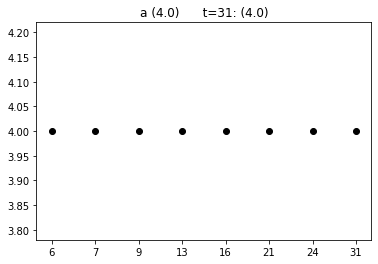

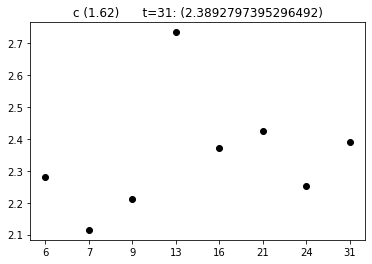

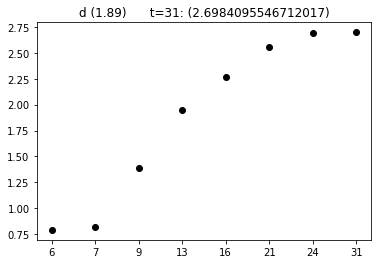

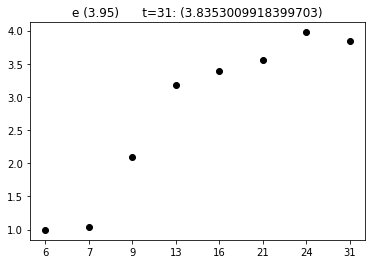

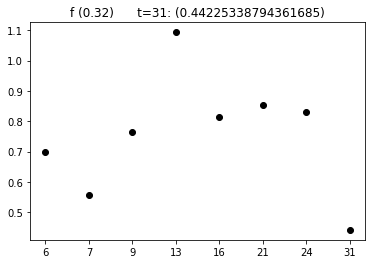

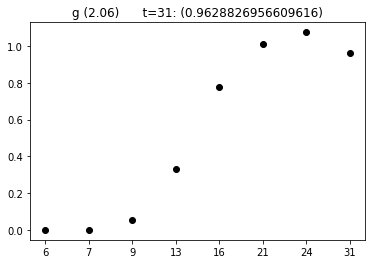

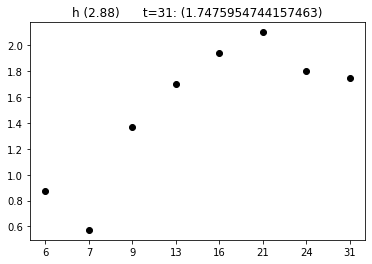

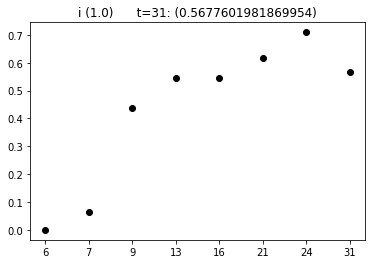

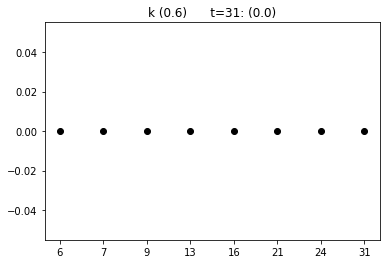

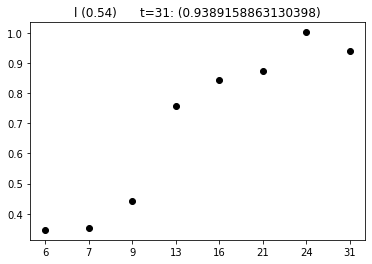

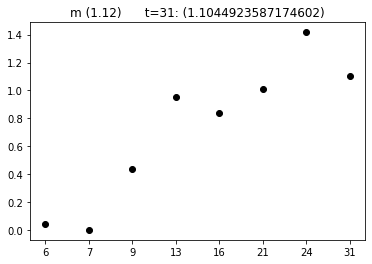

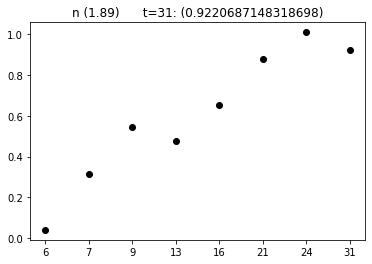

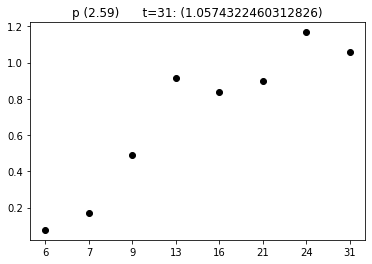

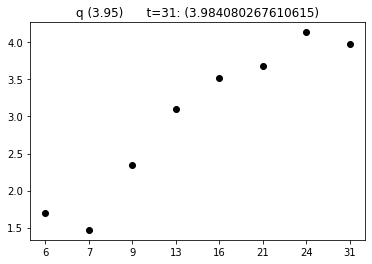

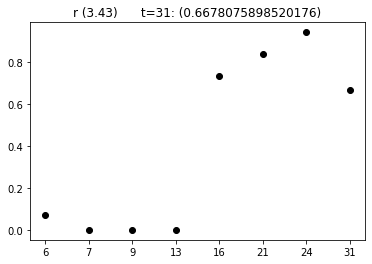

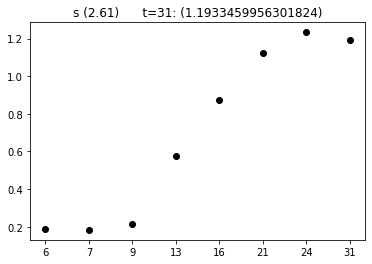

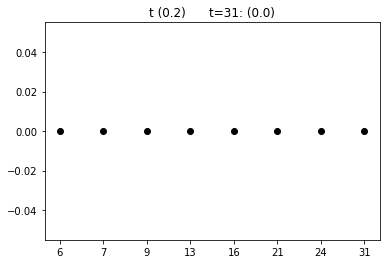

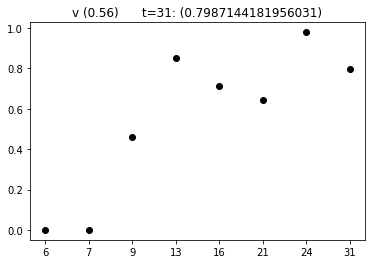

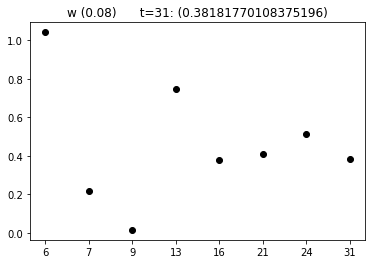

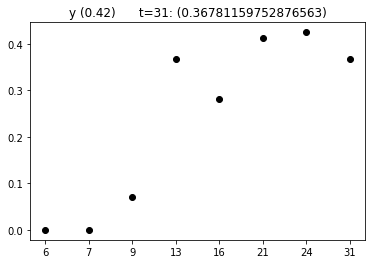

In [8]:
for i in range(len(all_AAs1)):
    plt.scatter(range(8),evals2[:,i],c='k')
    plt.xticks(np.arange(8), times[3:])
    plt.title(all_AAs1[i]+f" ({trueval[i]})"+f"      t=31: ({evals2[:,i][-1]})")
#     plt.hlines(y=trueval[i],xmin=0,xmax=8)
    plt.show()
    

In [9]:
print("\nValues\n","\n".join([all_AAs1[index]+"= "+str(x) for index,x in enumerate(sol)]))


Values
 a= 4
c= 2.3892797395296492
d= 2.6984095546712017
e= 3.8353009918399703
f= 0.44225338794361685
g= 0.9628826956609616
h= 1.7475954744157463
i= 0.5677601981869954
k= 0.0
l= 0.9389158863130398
m= 1.1044923587174602
n= 0.9220687148318698
p= 1.0574322460312826
q= 3.984080267610615
r= 0.6678075898520176
s= 1.1933459956301824
t= 0.0
v= 0.7987144181956031
w= 0.38181770108375196
y= 0.36781159752876563


In [10]:
print("proteins",len(proteins),"peptides",res.shape[0])

proteins 23 peptides 345


In [11]:
res=res.sort_values(by='dif')
res.head(20)

,peptides,True_NEH,e_NEH,dif
18,_KLAEKDEEMEQAK_4,32.0,32.067102,0.067102
24,_LAEKDEEMEQAK_3,32.0,32.067102,0.067102
17,_KLAEKDEEMEQAK_3,32.0,32.067102,0.067102
14,_KAITDAAMMAEELK_3,30.0,30.084672,0.084672
9,_LLETIDQLHLEFAK_3,25.0,24.866364,0.133636
36,_LEAPDIDLDLELR_2,26.0,25.814494,0.185506
39,_LIVEGAVVEFVK_2,18.0,17.777272,0.222728
8,_VGEATETALTcLVEK_2,26.0,26.333326,0.333326
6,_ENYGELADccTK_2,22.0,22.33925,0.33925
9,_SLADDAAYQcVVGGEK_2,34.0,33.628748,0.371252


In [12]:
res.tail(20)

,peptides,True_NEH,e_NEH,dif
48,_SEAPPHIFSISDNAY_2,34.0,24.843863,9.156137
1,_EVYMGNVIQGGEGQAPTR_2,39.0,29.775095,9.224905
63,_VLDSPGPPANITVR_2,26.0,16.720916,9.279084
14,_DSGYYSLTAENSSGSDTQK_2,37.0,27.705304,9.294696
3,_DAEEGPVEDTKPKPSR_3,37.0,27.69777,9.30223
2,_AGDSIVLSAISILGKPLPK_3,33.0,23.63782,9.36218
6,_TPIGSFLGSLASQPATK_3,32.0,22.492593,9.507407
0,_GGVSMPLSFAVTPYGYASK_2,31.0,21.402264,9.597736
7,_VNIHGGAVSLGHPIGM_3,29.0,19.295926,9.704074
3,_PSDLAGPVVAETRPGTK_3,34.0,24.029271,9.970729


In [13]:
temp=pd.DataFrame(coefficients)
temp.columns=all_AAs1
temp 

,a,c,d,e,f,g,h,i,k,l,m,n,p,q,r,s,t,v,w,y
0,0.454648,0.0,-0.318028,-1.090704,0.000000,-0.772676,1.000000,2.0,-2.318028,0.454648,1.000000,1.000000,0.000000,-0.772676,0.000000,1.227324,0.227324,0.000000,0.0,-0.772676
1,0.285714,0.0,-0.428571,-1.142857,0.000000,-0.714286,0.000000,0.0,-0.428571,-1.428571,0.000000,0.000000,0.000000,1.000000,0.000000,-0.714286,-0.714286,0.000000,0.0,-0.714286
2,0.086957,0.0,0.173913,0.260870,0.000000,0.086957,0.000000,0.0,0.173913,0.173913,0.000000,0.000000,0.000000,0.000000,0.000000,0.086957,0.086957,0.000000,0.0,0.086957
3,-2.467690,0.0,0.266155,2.133077,0.000000,1.000000,0.000000,0.0,1.133077,1.133077,0.000000,-0.866923,0.000000,0.000000,-0.866923,0.133077,0.133077,-0.866923,0.0,1.000000
4,2.959999,0.0,-0.080001,-2.120002,0.000000,-1.040001,0.000000,0.0,-2.120002,-2.120002,0.000000,1.000000,0.000000,0.000000,1.000000,-0.040001,-0.040001,1.000000,0.0,-1.040001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
311,2.136364,0.0,0.000000,-0.863636,0.136364,-1.454545,0.000000,0.0,0.136364,-0.727272,1.136364,-1.727272,-0.863636,0.000000,0.000000,0.000000,2.000000,-0.863636,0.0,0.000000
312,-0.722114,0.0,-0.430528,0.138943,0.569472,3.569472,0.000000,0.0,0.569472,1.138943,1.000000,2.000000,1.000000,-0.861057,0.000000,-0.430528,-0.430528,-0.291585,0.0,0.000000
313,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
314,2.257955,0.0,1.000000,-1.484091,1.000000,-0.742045,-1.742045,0.0,-0.742045,0.257955,0.000000,0.000000,-1.742045,0.257955,0.000000,-2.484091,-0.742045,3.000000,0.0,-1.742045


In [14]:
# for c in range( len(coefficients)):
#     print(np.dot(coefficients[c],sol))